In [1]:
import numpy as np
import bolton
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist import Subplot
from matplotlib.ticker import FuncFormatter, Formatter
from mpl_toolkits.axisartist.grid_helper_curvelinear import GridHelperCurveLinear

In [2]:
# Variables

C_to_K = 273.15
skew_slope = 40

# Equations

y = -ln(P)
x = T - skew_slope*ln(P)

In [3]:
def x_from_TP(T,P):
    x = T - skew_slope*np.log(P)
    return x
def y_from_P(P):
    y = -1*np.log(P)
    return y
def T_from_xP(x,P):
    T = x + skew_slope*np.log(P)
    return T
def P_from_y(y):
    P = np.exp(-y)
    return P
def to_thermo(x,y):
    """Transform (x,y) coordinates to T in degrees Celsius and P in mb"""
    P = P_from_y(y)
    T_C = T_from_xP(x,P) - C_to_K
    return T_C, P
def from_thermo(T_C,P):
    """Transform T_C (in degrees Celisus) and P (in mb) to (x,y)"""
    y = y_from_P(P)
    x = x_from_TP(T_C+C_to_K,P)
    return x,y

In [4]:
# values along the bottom and left edges
P_bottom = 1050.0
P_top = 150.
T_min = -40 + C_to_K
T_max = 50 + C_to_K
x_min = x_from_TP(T_min,P_bottom)
x_max = x_from_TP(T_max,P_top)
y_min = y_from_P(P_bottom)
y_max = y_from_P(P_top)

In [5]:
P_levels = np.arange(1000, 150-50, -50)
T_C_levels = np.arange(-80, 41, 10)
T_levels = T_C_levels + C_to_K
theta_levels = np.arange(-40+C_to_K, 101+C_to_K, 10)
theta_ep_levels = theta_levels.copy()
mixing_ratios = np.asarray([0.4, 1, 2, 3, 4, 8, 12, 16, 20])/1000.

In [6]:
P_all = np.arange(P_bottom, P_top-1, -1)
y_P_levels = y_from_P(P_levels)
y_all_P = y_from_P(P_all)
x_T_levels = [x_from_TP(Ti, P_all) for Ti in T_levels]
x_thetas = [x_from_TP(bolton.theta_dry(theta_i, P_all), P_all) for theta_i in theta_levels]
x_mixing_ratios = [x_from_TP(bolton.mixing_ratio_line(P_all, mixing_ratios_i)+C_to_K, P_all) for mixing_ratios_i in mixing_ratios]
mesh_T, mesh_P = np.meshgrid(np.arange(-60.0, T_levels.max()-C_to_K+0.1, 0.1), P_all)
theta_ep_mesh = bolton.theta_ep_field(mesh_T, mesh_P)
#print(theta_ep_mesh)
print(bolton.pseudoeq_potential_T(25,950,0.021,P_0=1000.))

385.6683327254669


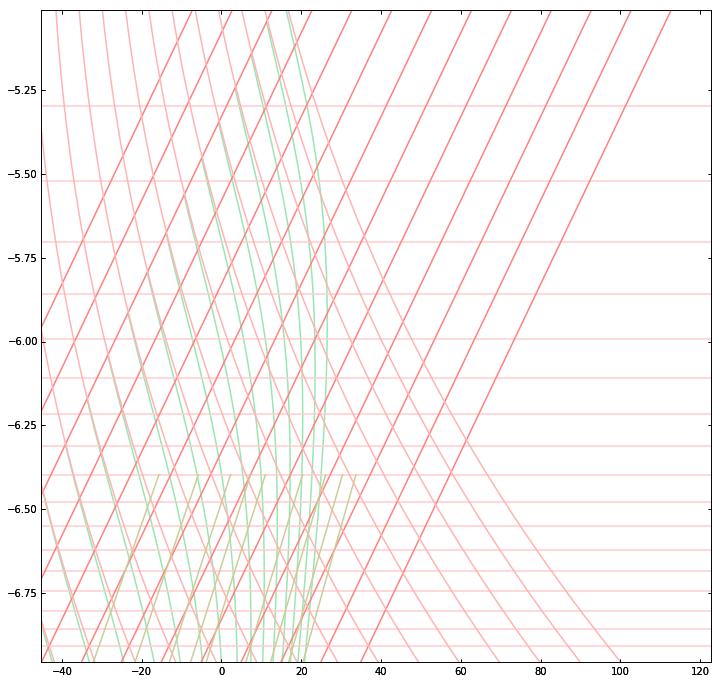

In [7]:
fig = plt.figure(1, figsize = (12,12))
ax = Subplot(fig, 1, 1, 1)
fig.add_subplot(ax)

for yi in y_P_levels:
    ax.plot((x_min, x_max), (yi,yi), color = (1., 0.8, 0.8))
for x_T in x_T_levels:
    ax.plot(x_T, y_all_P, color = (1., 0.5, 0.5))
for x_theta in x_thetas:
    ax.plot(x_theta, y_all_P, color = (1., 0.7, 0.7))
for x_mixing_ratio in x_mixing_ratios:
    good = P_all >= 600 # restrict mixing ratio lines to below 600 mb
    ax.plot(x_mixing_ratio[good], y_all_P[good], color = (0.8, 0.8, 0.6))
n_moist = len(theta_ep_levels)
moist_colors = ((0.6, 0.9, 0.7),)*n_moist
ax.contour(x_from_TP(mesh_T+C_to_K, mesh_P), y_from_P(mesh_P), theta_ep_mesh, theta_ep_levels, colors = moist_colors)
ax.axis((x_min, x_max, y_min, y_max))
plt.show()